(stan-hier_beta_binom_model)=
# Modello gerarchico beta-binomiale con Stan

In questo capitolo, esploreremo il concetto di modellazione gerarchica nel contesto Bayesiano. Partiamo da un esempio semplice per introdurre la stima statistica: consideriamo un'urna con palline di colore blu e rosso. Estraendo un campione di 10 palline, possiamo stimare la proporzione di palline blu presenti nell'urna. Questo scenario classico ci introduce ai fondamenti della stima statistica.

Immaginiamo ora una situazione più complessa: abbiamo a disposizione una grande urna che contiene al suo interno 10 urne più piccole, ciascuna delle quali è riempita con proprie palline blu e rosse. Supponiamo di scegliere 7 di queste urne minori ed estrarre 10 palline da ciascuna. La questione è: come analizziamo questi dati?

Una possibile soluzione è trattare ogni urna piccola come un'entità completamente indipendente, ripetendo il problema statistico base per sette volte. Questo metodo, tuttavia, non è ideale perché assume che non ci sia nessuna correlazione tra le urne piccole, ignorando il fatto che tutte provengono da una urna comune più grande che potrebbe influenzarne il contenuto.

Un altro metodo potrebbe essere quello di ignorare completamente la presenza delle urne minori e focalizzarsi unicamente sulla stima della proporzione totale di palline blu nell'urna grande. Questo approccio, però, trascura completamente la struttura gerarchica dei dati, ossia il fatto che le palline sono organizzate in urne separate.

Il metodo più appropriato per analizzare questa situazione è attraverso la modellazione gerarchica. Con questo approccio, ci proponiamo di stimare non solo la proporzione di palline blu in ogni urna minore, ma anche di comprendere quanto le urne sono correlate tra loro. L'urna grande funge da modello generativo per le urne più piccole, e comprendere questa relazione sottostante ci consente di fare previsioni più accurate sulla proporzione di palline blu in ogni urna minore, riconoscendo e sfruttando la struttura gerarchica dei dati.

In [14]:
import logging
import os
import warnings
from io import StringIO

import requests

warnings.simplefilter(action='ignore', category=FutureWarning)

import cmdstanpy
from cmdstanpy import CmdStanModel

cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

In [15]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "stan_hier_beta_binomial"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(
    home_directory, '_repositories', 'ds4p')

%config InlineBackend.figure_format = "retina"

## Analisi bayesiana della "terapia tattile" 

Esaminiamo un problema presentato nel lavoro di {cite:t}`doing_bayesian_data_an` riguardante la "terapia tattile" (Therapeutic Touch), una pratica infermieristica incentrata sulla manipolazione del presunto "campo energetico" di un paziente. Nonostante la sua prevalenza nelle scuole di infermieristica e negli ospedali negli Stati Uniti, come riportato da {cite:t}`rosa1998close`, evidenze empiriche a supporto della sua efficacia sono scarse o assenti.

Il focus dell'indagine di {cite:t}`rosa1998close` è una delle asserzioni cardine degli operatori di terapia tattile: la presunta capacità di percepire i campi energetici senza contatto visivo. Per testare questa affermazione, è stato progettato un esperimento in cui gli operatori ponevano le loro mani attraverso un pannello che bloccava la visione. In ciascuna prova, un esaminatore, seguendo l'esito di un lancio di moneta, posizionava la sua mano sopra una delle mani dell'operatore. L'operatore doveva quindi identificare quale delle sue mani era stata "selezionata" dall'esaminatore. Ogni tentativo è stato classificato come "corretto" o "errato".

L'unità di osservazione in questo esperimento è costituita da un set di 10 prove per operatore. In totale, lo studio ha coinvolto 21 operatori, con sette di loro sottoposti a retest dopo circa un anno. I dati di retest sono stati trattati come entità indipendenti, portando a un campione effettivo di 28 osservazioni. La metrica di interesse è la proporzione di risposte corrette per ciascun operatore, con una proporzione attesa di 0.50 sotto l'ipotesi nulla di performance casuale.

La domanda della ricerca centrale è se il campione nel suo complesso è in grado di ottenere una prestazione superiore a quella attesa in base al caso soltanto e, inoltre, se vi sono variazioni  nelle prestazioni individuali.

Inizieremo importando i dati forniti da {cite:t}`doing_bayesian_data_an`.

In [16]:
# Define the URL of the CSV file on GitHub
url = "https://raw.githubusercontent.com/boboppie/kruschke-doing_bayesian_data_analysis/master/2e/TherapeuticTouchData.csv"
# Download the content of the CSV file
response = requests.get(url)
tt_dat = pd.read_csv(StringIO(response.text))
print(tt_dat.head())

   y    s
0  1  S01
1  0  S01
2  0  S01
3  0  S01
4  0  S01


In [17]:
tt_dat.shape

(280, 2)

Nella colonna `y`, il valore 1 indica una risposta corretta, mentre 0 indica una risposta errata. La seconda colonna contiene il codice identificativo di ciascun operatore.

Calcoliamo la proporzione di risposte corrette per ciascun operatore.

In [18]:
tt_agg = tt_dat.groupby("s").agg(proportion_correct=("y", "mean")).reset_index()
tt_agg

s  proportion_correct
0   S01                 0.1
1   S02                 0.2
2   S03                 0.3
3   S04                 0.3
4   S05                 0.3
5   S06                 0.3
6   S07                 0.3
7   S08                 0.3
8   S09                 0.3
9   S10                 0.3
10  S11                 0.4
11  S12                 0.4
12  S13                 0.4
13  S14                 0.4
14  S15                 0.4
15  S16                 0.5
16  S17                 0.5
17  S18                 0.5
18  S19                 0.5
19  S20                 0.5
20  S21                 0.5
21  S22                 0.5
22  S23                 0.6
23  S24                 0.6
24  S25                 0.7
25  S26                 0.7
26  S27                 0.7
27  S28                 0.8

Costruiamo un modello gerarchico partendo dall'ipotesi che il numero di risposte corrette di ciascun operatore sia modellato da una variabile casuale binomiale. Per ciascuno dei ventotto operatori, possiamo esprimere questo come segue:

$$
y_i \sim \text{Binomial}(n_i, p_i),
$$

dove $i = 0, \dots, 27$.

Per modellare la distribuzione a priori del parametro sconosciuto $p_i$, possiamo utilizzare una distribuzione Beta con parametri $a$ e $b$ -- si veda {cite:t}`doingbayesian`:

$$
p_i \sim \text{Beta}(a, b).
$$

È importante notare che gli iperparametri $a$ e $b$ sono condivisi tra tutti gli operatori, caratteristica che definisce un modello gerarchico.

Se $a$ e $b$ sono noti, la distribuzione a posteriori del parametro $p$ per ciascun operatore, dati i risultati osservati $y_i$, è anch'essa una distribuzione Beta:

$$
p_i \mid y_i \sim \text{Beta}(a + y_i, b + n_i - y_i). 
$$

Nel caso più generale, dove gli iperparametri $a$ e $b$ sono incogniti, è necessario stabilire una distribuzione a priori anche per questi. Nell'esempio seguente, useremo i seguenti prior:

$$
a \sim \text{Gamma}(8, 12)\\ 
b \sim \text{Gamma}(27, 5)
$$

Per applicare il modello gerarchico descritto sopra ai dati del *therapeutic touch*, iniziamo a calcolare il numero di risposte corrette di ciascun operatore.

In [19]:
result = tt_dat.groupby("s")["y"].sum().reset_index()
y = result["y"]
print(y)

0     1
1     2
2     3
3     3
4     3
5     3
6     3
7     3
8     3
9     3
10    4
11    4
12    4
13    4
14    4
15    5
16    5
17    5
18    5
19    5
20    5
21    5
22    6
23    6
24    7
25    7
26    7
27    8
Name: y, dtype: int64


Creiamo il vettore `N` che fornisce il numero di prove per ciascun operatore.

In [20]:
N = tt_dat.groupby("s")["y"].count()

Esaminiamo dunque i dati a disposizione.

In [21]:
print(*N)

10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10


In [22]:
print(y)

0     1
1     2
2     3
3     3
4     3
5     3
6     3
7     3
8     3
9     3
10    4
11    4
12    4
13    4
14    4
15    5
16    5
17    5
18    5
19    5
20    5
21    5
22    6
23    6
24    7
25    7
26    7
27    8
Name: y, dtype: int64


Creaiamo un dizionario con i dati necessari per Stan.

In [23]:
data = {
    "N": 28,
    "y": y.tolist(),
    "n_trials": N.tolist()
}

print(data)

{'N': 28, 'y': [1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 8], 'n_trials': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]}


## Modello Stan

Leggiamo il codice Stan che implementa il modello descritto nel capitolo {ref}`hier_beta_binom_model`.

In [24]:
stan_file = os.path.join('stan', 'h_beta_binom_model.stan')
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> N;  // Number of participants
  array[N] int<lower=0> y;  // Number of successes for each participant
  array[N] int<lower=0> n_trials;  // Number of trials for each participant
}

parameters {
  real<lower=0> alpha;  // Alpha parameter for the Beta distribution
  real<lower=0> beta;   // Beta parameter for the Beta distribution
  array[N] real<lower=0, upper=1> p;  // Success probability for each participant
}

model {
  // Priors
  alpha ~ gamma(8, 2);
  beta ~ gamma(27, 5);
  
  // Each participant's success probability follows a Beta distribution
  p ~ beta(alpha, beta);
  
  // Likelihood of the observed data
  for (i in 1:N) {
    y[i] ~ binomial(n_trials[i], p[i]);
  }
}

generated quantities {
  real overall_p = alpha / (alpha + beta);  // Calculate the mean success probability
}



Nel nostro modello:
- `N` è il numero totale di partecipanti
- `y` è un array che contiene il numero di successi per ogni partecipante
- `n_trials` è un array che contiene il numero di prove per ogni partecipante

### Il concetto di gerarchia

Il modello è chiamato "gerarchico" perché considera due livelli:
1. Il livello individuale: ogni partecipante ha la propria probabilità di successo
2. Il livello di gruppo: c'è una distribuzione generale che descrive come variano le probabilità di successo tra i partecipanti

### Spiegazione del modello

#### Parametri

- `p`: È un array che contiene la vera probabilità di successo per ogni partecipante. 
- `alpha` e `beta`: Sono i parametri che definiscono la distribuzione Beta, che descrive come variano le probabilità di successo tra i partecipanti.

#### Prior

Impostiamo delle prior per `alpha` e `beta`:
```
alpha ~ gamma(8, 2);
beta ~ gamma(27, 5);
```
Queste prior riflettono le nostre conoscenze o supposizioni iniziali sui possibili valori di questi parametri.

#### Il cuore del modello

```
p ~ beta(alpha, beta);
```
Questa riga è il cuore del modello gerarchico. Dice che la probabilità di successo di ogni partecipante (`p`) segue una distribuzione Beta, i cui parametri sono `alpha` e `beta`. Questo crea un legame tra tutti i partecipanti: le loro prestazioni individuali sono considerate come variazioni attorno a una tendenza generale del gruppo.

#### Likelihood

```
for (i in 1:N) {
  y[i] ~ binomial(n_trials[i], p[i]);
}
```
Questa parte del modello descrive come i dati osservati (`y`) sono generati, dato il numero di prove (`n_trials`) e la vera probabilità di successo (`p`) per ogni partecipante.

### Quantità generate

```
real overall_p = alpha / (alpha + beta);
```
Questa riga calcola la probabilità di successo media per l'intero gruppo.

### Conclusione

Questo modello ci permette di:
1. Stimare la probabilità di successo individuale per ogni partecipante
2. Comprendere come queste probabilità variano nel gruppo
3. Ottenere una stima della probabilità di successo media per l'intero gruppo

Il vantaggio principale di questo approccio gerarchico è che combina informazioni a livello individuale e di gruppo, permettendo stime più precise, specialmente per i partecipanti con pochi dati.

## Compilazione e sampling

Compiliamo il modello.

In [25]:
model = CmdStanModel(stan_file=stan_file)

Eseguiamo il campionamento MCMC.

In [26]:
fit = model.sample(
    data=data,
    iter_warmup=2000, iter_sampling=4000,
    seed=84735, chains=4,
    show_progress=False, show_console=False
)

## Esame delle distribuzioni a posteriori

Esaminiamo le stime a posteriori dei parametri.

In [27]:
az.summary(fit, var_names=(["alpha", "beta", "p"]), hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha  4.591  0.866     2.991      6.359      0.008    0.006   10600.0   
beta   5.756  0.932     4.009      7.623      0.008    0.006   12032.0   
p[0]   0.273  0.100     0.091      0.469      0.001    0.000   20279.0   
p[1]   0.324  0.103     0.129      0.524      0.001    0.001   20614.0   
p[2]   0.373  0.107     0.174      0.588      0.001    0.001   20791.0   
p[3]   0.372  0.106     0.179      0.590      0.001    0.001   22416.0   
p[4]   0.373  0.107     0.173      0.582      0.001    0.001   22260.0   
p[5]   0.374  0.106     0.173      0.583      0.001    0.001   21443.0   
p[6]   0.372  0.106     0.172      0.580      0.001    0.001   21992.0   
p[7]   0.372  0.106     0.173      0.582      0.001    0.001   21133.0   
p[8]   0.372  0.105     0.176      0.583      0.001    0.001   21459.0   
p[9]   0.372  0.108     0.167      0.580      0.001    0.001   22007.0   
p[10]  0.422  0.108     0.209      0.627      0.001    0.001   21331.0   
p[11]  0.421  0.109     0.217      0.634      0.001    0.001   22045.0   
p[12]  0.422  0.108     0.213      0.632      0.001    0.001   22874.0   
p[13]  0.421  0.110     0.214      0.637      0.001    0.001   22807.0   
p[14]  0.421  0.109     0.213      0.634      0.001    0.001   21851.0   
p[15]  0.471  0.112     0.257      0.689      0.001    0.001   22072.0   
p[16]  0.471  0.111     0.249      0.680      0.001    0.001   22559.0   
p[17]  0.470  0.111     0.258      0.683      0.001    0.001   23384.0   
p[18]  0.471  0.111     0.259      0.688      0.001    0.001   22495.0   
p[19]  0.471  0.111     0.264      0.691      0.001    0.001   22949.0   
p[20]  0.472  0.110     0.251      0.680      0.001    0.001   22288.0   
p[21]  0.472  0.109     0.264      0.685      0.001    0.001   24414.0   
p[22]  0.519  0.109     0.306      0.728      0.001    0.001   22363.0   
p[23]  0.521  0.111     0.305      0.732      0.001    0.001   20720.0   
p[24]  0.570  0.109     0.357      0.780      0.001    0.001   22438.0   
p[25]  0.570  0.109     0.349      0.772      0.001    0.001   20850.0   
p[26]  0.569  0.110     0.358      0.786      0.001    0.001   21973.0   
p[27]  0.620  0.107     0.409      0.821      0.001    0.001   22119.0   

       ess_tail  r_hat  
alpha   10141.0    1.0  
beta    11787.0    1.0  
p[0]    11628.0    1.0  
p[1]    11911.0    1.0  
p[2]    11355.0    1.0  
p[3]    11620.0    1.0  
p[4]    11753.0    1.0  
p[5]    12716.0    1.0  
p[6]    12317.0    1.0  
p[7]    11017.0    1.0  
p[8]    11369.0    1.0  
p[9]    11102.0    1.0  
p[10]   12556.0    1.0  
p[11]   11591.0    1.0  
p[12]   12190.0    1.0  
p[13]   12055.0    1.0  
p[14]   12199.0    1.0  
p[15]   10892.0    1.0  
p[16]   11739.0    1.0  
p[17]   11679.0    1.0  
p[18]   11479.0    1.0  
p[19]   11720.0    1.0  
p[20]   11847.0    1.0  
p[21]   12216.0    1.0  
p[22]   11502.0    1.0  
p[23]   11618.0    1.0  
p[24]   11048.0    1.0  
p[25]   12520.0    1.0  
p[26]   11715.0    1.0  
p[27]   11629.0    1.0

Le distribuzioni posteriori degli iperparametri, prese da sole, non hanno un significato chiaro. Tuttavia, possiamo utilizzarle per calcolare la distribuzione a posteriori della probabilità di una risposta corretta per tutto il gruppo.

Convertiamo l'oggetto `fit` creato da cmdstanpy in un oggetto InferenceData usando ArviZ:

In [28]:
idata = az.from_cmdstanpy(posterior=fit)

## Schrinkage bayesiano

Nel contesto dei modelli gerarchici bayesiani, il fenomeno dello "shrinkage" (o riduzione) è un aspetto fondamentale e desiderabile, specialmente quando si modellano dati provenienti da gruppi o sotto-popolazioni con campionature di dimensioni diverse o variazioni intrinseche. Questo fenomeno può essere particolarmente rilevante e utile nel tuo modello gerarchico per il numero di risposte corrette di ciascun operatore, modello che utilizza una distribuzione binomiale per le osservazioni e una Beta per i priori dei parametri di successo $ p_i $.

### Cosa Significa Shrinkage in un Modello Gerarchico?
Lo "shrinkage" in un modello bayesiano gerarchico si riferisce al processo per cui le stime dei parametri individuali (ad esempio, le probabilità di successo per ciascun operatore nel presente modello) sono "spostate" verso una media di gruppo. Questo accade perché il modello considera sia i dati osservati per ciascun gruppo (o individuo) sia le informazioni aggiuntive fornite dalla struttura gerarchica e dai dati degli altri gruppi.

### Meccanismo dello Shrinkage

Nel presente modello:
- Ogni operatore ha una probabilità di successo $ p_i $ che segue una distribuzione Beta $ \text{Beta}(a, b) $, dove $ a $ e $ b $ sono iperparametri condivisi tra tutti gli operatori.
- Gli iperparametri $ a $ e $ b $ sono stimati dai dati di tutti gli operatori, e quindi forniscono una base comune che riflette le caratteristiche medie di tutti gli operatori.

Se un operatore ha pochi dati (ad esempio, pochi tentativi o risposte), la stima di $ p_i $ per quell'operatore sarà fortemente influenzata dai valori di $ a $ e $ b $, "spostando" la stima di $ p_i $ verso la media di gruppo. Questo riduce l'impatto delle fluttuazioni casuali nei dati di quell'operatore, che potrebbero altrimenti portare a stime eccessivamente ottimistiche o pessimistiche.

### Benefici dello Shrinkage
1. **Migliore Stima per Gruppi con Pochi Dati**: Operatori con meno dati beneficiano maggiormente dello shrinkage, in quanto le loro stime sono stabilizzate attraverso l'informazione "prestata" dagli altri operatori.
2. **Riduzione dell'Overfitting**: Il modello evita di adattarsi troppo ai dati di un singolo operatore, specialmente quando questi sono limitati o rumorosi, risultando in generalizzazioni più robuste.
3. **Incorporazione della Struttura dei Dati**: Lo shrinkage riflette l'assunzione che gli operatori siano simili ma non identici, permettendo una certa individualità ma entro un quadro comune che li lega.

Supponiamo che alcuni operatori abbiano mostrato risultati estremamente buoni o cattivi, che potrebbero essere dovuti a varianze casuali. Lo shrinkage modera queste stime estreme, specialmente se non sono supportate da una grande quantità di dati, rendendo le previsioni finali più credibili e meno soggette a errori casuali.

In conclusione, lo shrinkage in un modello gerarchico aiuta a ottenere stime più accurate e credibili per tutti i membri del gruppo, sfruttando le informazioni collettive e limitando l'impatto delle anomalie nei dati individuali.

Per rappresentare visivamente questo fenomeno, iniziamo con il recuperare le stime a posteriori di  `alpha` e `beta`.

In [29]:
alphas = idata.posterior["alpha"]
betas = idata.posterior["beta"]

Creiamo un array che contiene le stime bayesiane della probabilità di successo di ciascun operatore fornite sopra dalla funzione `summary` di ArviZ. Per fare questo usiamo le funzionalità di `xarray`.

In [31]:
# Calcola la media lungo le dimensioni 'chain' e 'draw'
bayesian_estimates = idata.posterior["p"].mean(dim=("chain", "draw"))
print(bayesian_estimates.values)

[0.27273311 0.32377131 0.37344338 0.37214022 0.37257493 0.37351838
 0.37219305 0.37214675 0.37185773 0.37173435 0.42165569 0.42127528
 0.42172633 0.42118034 0.42149943 0.47116033 0.47087155 0.46970487
 0.47107502 0.47138671 0.47205312 0.47221249 0.51906367 0.52052519
 0.57032404 0.57017976 0.56928041 0.62016621]


Generiamo un array con le probabilità empiriche.

In [32]:
# Empirical probabilities
empirical_probs = y.values / N.values
print(empirical_probs)

[0.1 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4 0.4 0.4 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.6 0.6 0.7 0.7 0.7 0.8]


Il grafico seguente confronta le probabilità empiriche con le stime Bayesiane per la probabilità di successo associata a ciascun operatore. Questa rappresentazione evidenzia il fenomeno di "shrinkage" intrinseco ai modelli Bayesiani gerarchici. In particolare, il grafico illustra come le stime Bayesiane delle probabilità di successo per gli operatori tendono a convergere verso la media generale, in confronto alle probabilità empiriche. 

In [33]:
# Calcola la media generale delle probabilità empiriche
mean_empirical_prob = np.mean(empirical_probs)
mean_empirical_prob

0.43928571428571417

In [34]:
# Calcola la media generale delle stime Bayesiane
mean_bayesian_estimate = np.mean(bayesian_estimates)
mean_bayesian_estimate

<xarray.DataArray 'p' ()> Size: 8B
array(0.44112334)

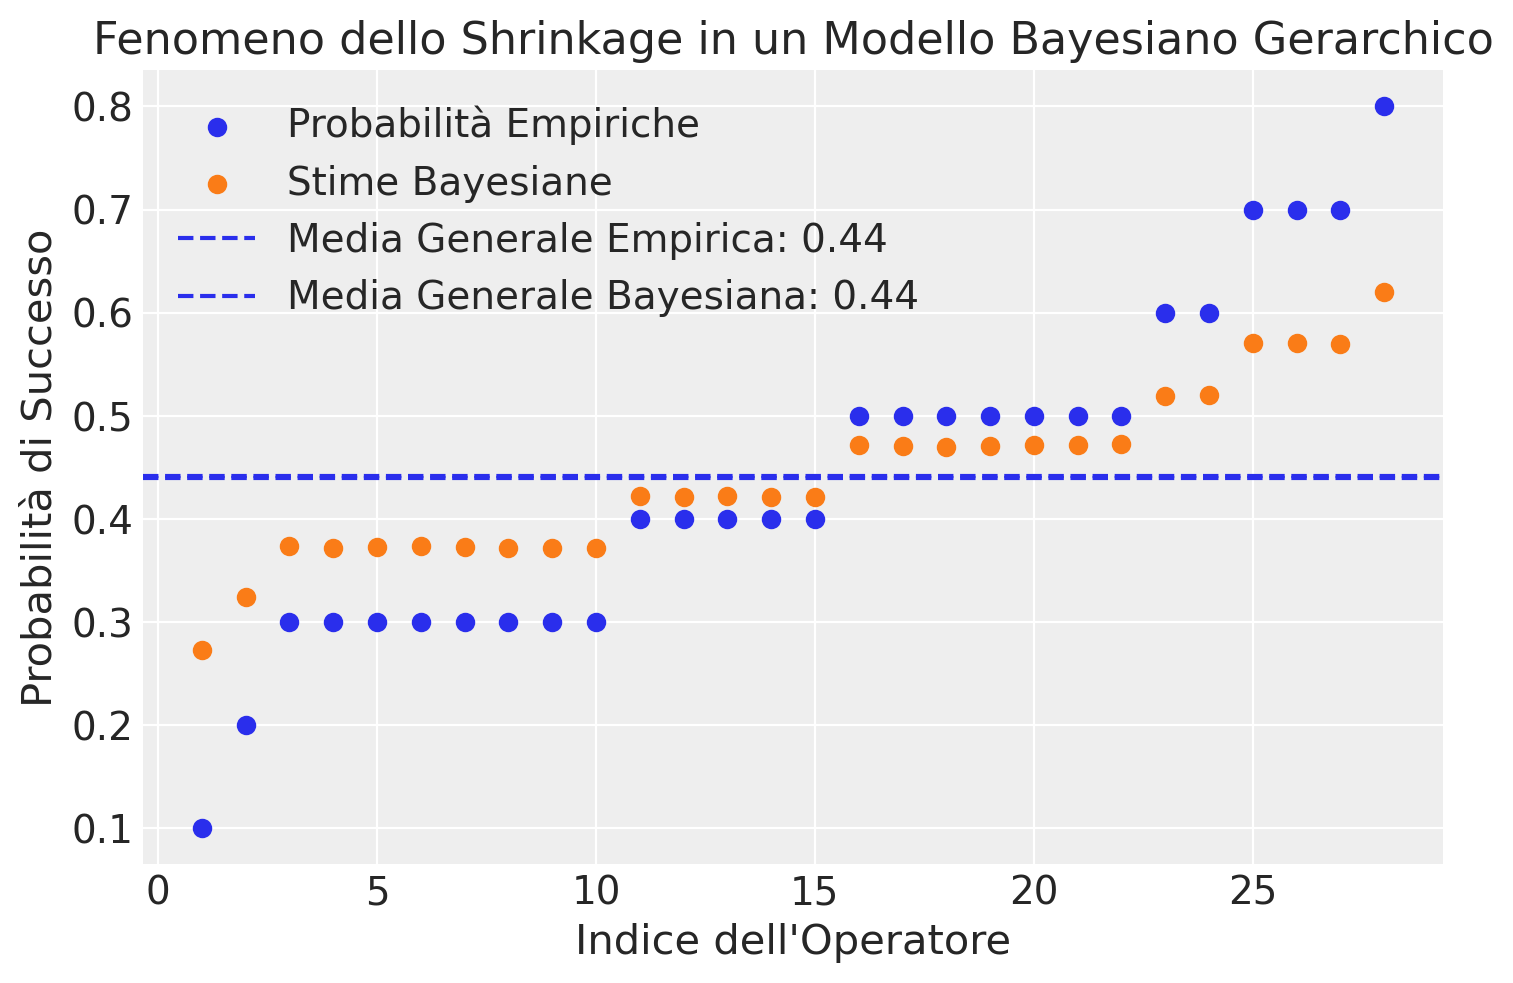

In [35]:
# Crea il grafico
plt.figure()

# Traccia le probabilità empiriche
plt.scatter(range(1, 29), empirical_probs, label="Probabilità Empiriche")

# Traccia le stime Bayesiane
plt.scatter(range(1, 29), bayesian_estimates, color="C1", label="Stime Bayesiane")

# Aggiungi linee orizzontali per indicare le medie generali
plt.axhline(
    y=mean_empirical_prob,
    linestyle="--",
    label=f"Media Generale Empirica: {mean_empirical_prob:.2f}",
)
plt.axhline(
    y=mean_bayesian_estimate,
    linestyle="--",
    label=f"Media Generale Bayesiana: {mean_bayesian_estimate:.2f}",
)

# Etichette e titolo
plt.xlabel("Indice dell'Operatore")
plt.ylabel("Probabilità di Successo")
plt.title("Fenomeno dello Shrinkage in un Modello Bayesiano Gerarchico")
plt.legend()
plt.show()

Esaminiamo la distribuzione a posteriori dei parametri `alpha` e `beta`.

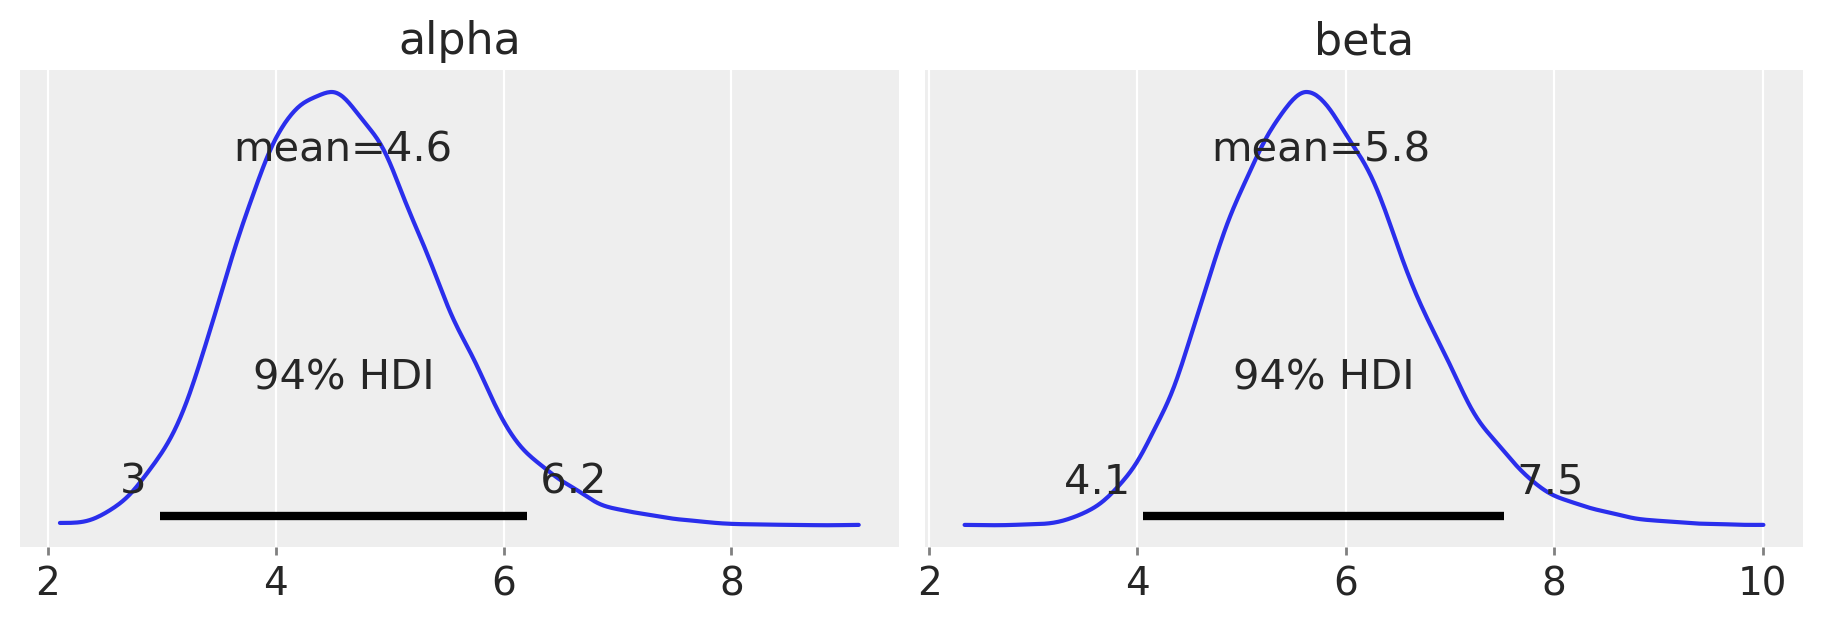

In [36]:
az.plot_posterior(idata, var_names=["alpha", "beta"], figsize=(9, 3))
plt.show()

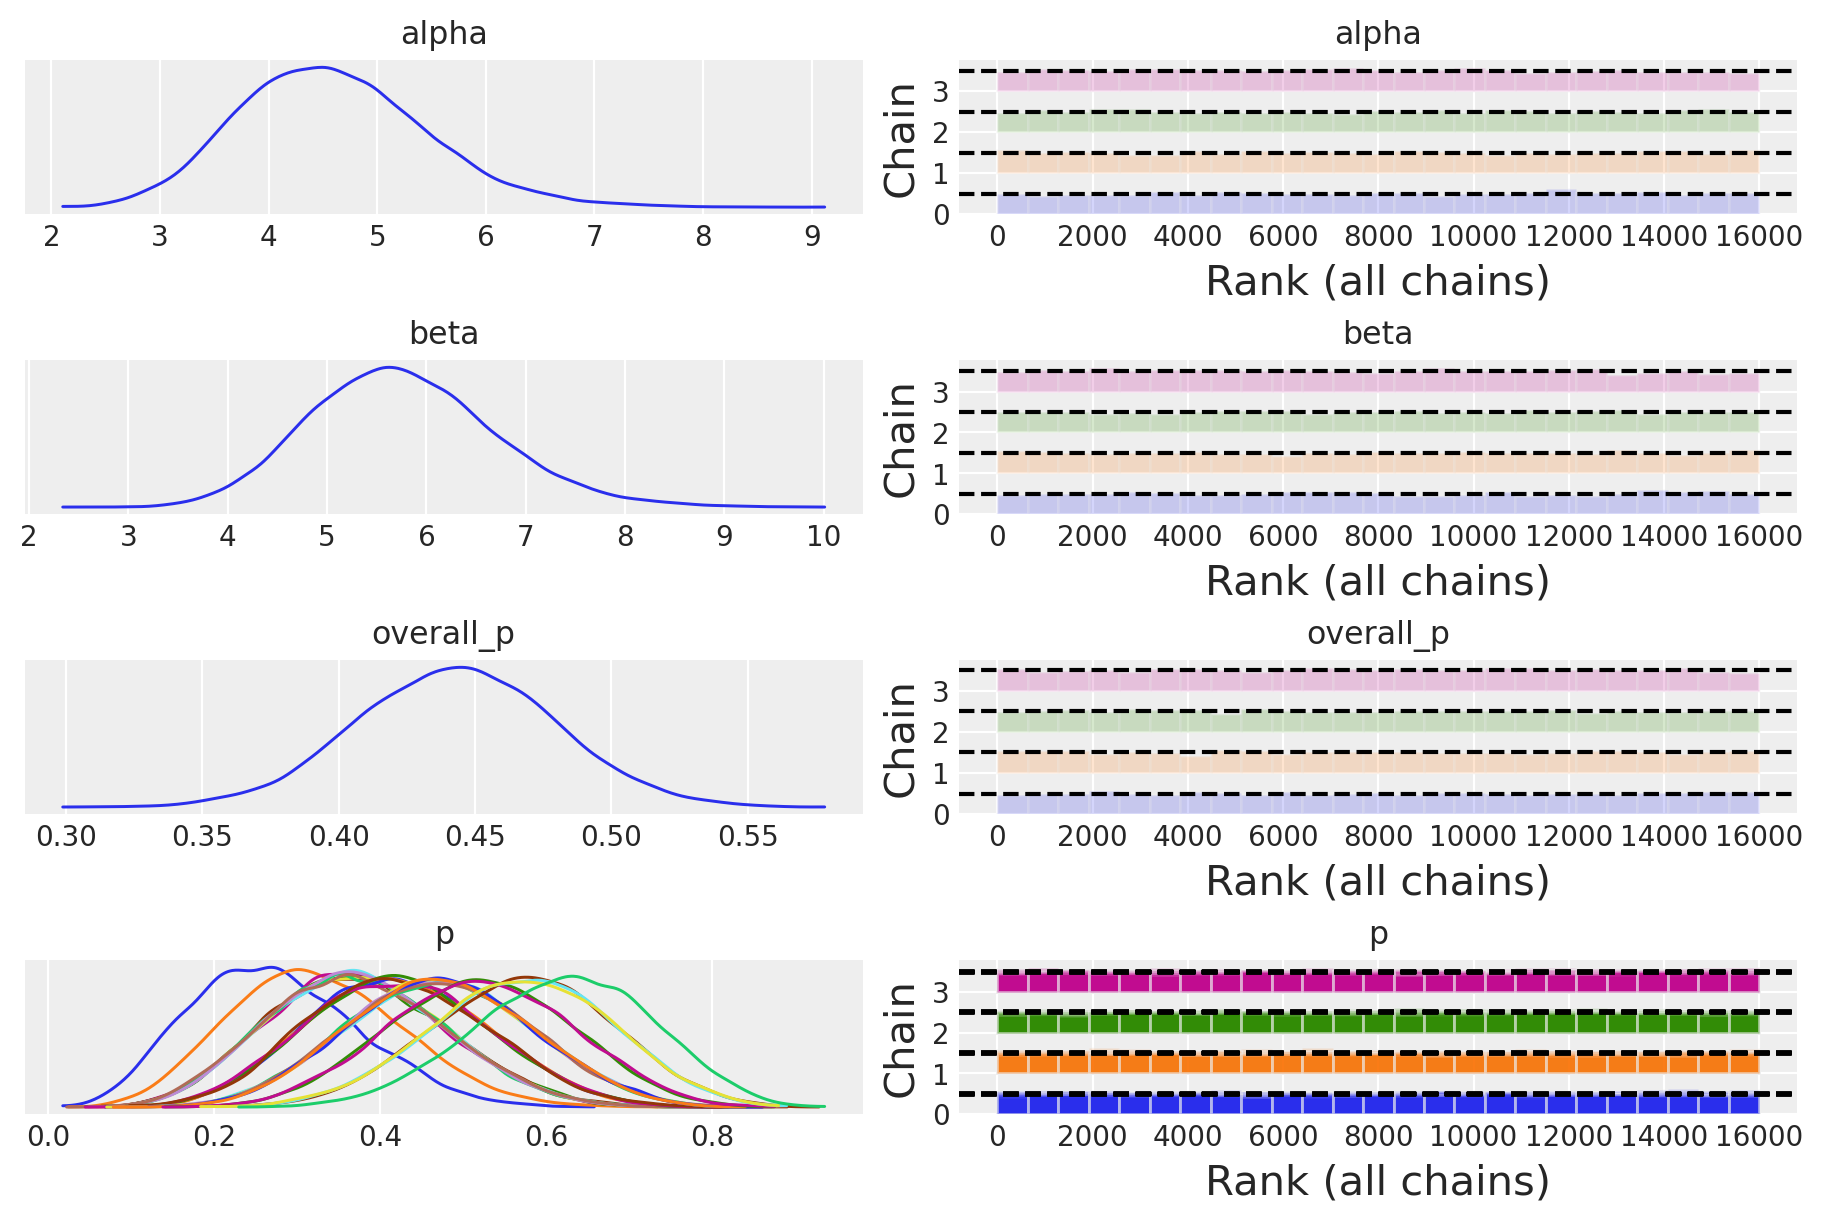

In [37]:
_ = az.plot_trace(idata, combined=True, figsize=(9, 6), kind="rank_bars")

Le distribuzioni posteriori degli iperparametri, prese da sole, non hanno un significato chiaro. Tuttavia, possiamo utilizzarle per calcolare la distribuzione a posteriori della probabilità di una risposta corretta per tutto il gruppo.

In [38]:
# Function to calculate the mean of a Beta distribution
def beta_mean(alpha, beta):
    return alpha / (alpha + beta)


# Calculate the means for each pair of alpha and beta
sample_posterior_x_means = np.array([beta_mean(a, b) for a, b in zip(alphas, betas)])

In [39]:
sample_posterior_x_means.shape

(4, 4000)

In [40]:
sample_posterior_x_means

array([[0.37604496, 0.41922669, 0.47345362, ..., 0.49569844, 0.47777766,
        0.4247707 ],
       [0.45096577, 0.41051049, 0.49462864, ..., 0.50996786, 0.53271226,
        0.4371311 ],
       [0.47134244, 0.47201767, 0.44473739, ..., 0.35595368, 0.41136842,
        0.46184053],
       [0.36027889, 0.42282699, 0.43706697, ..., 0.41162794, 0.43983373,
        0.46031791]])

In [41]:
print(sample_posterior_x_means.mean())

0.4428264916259948


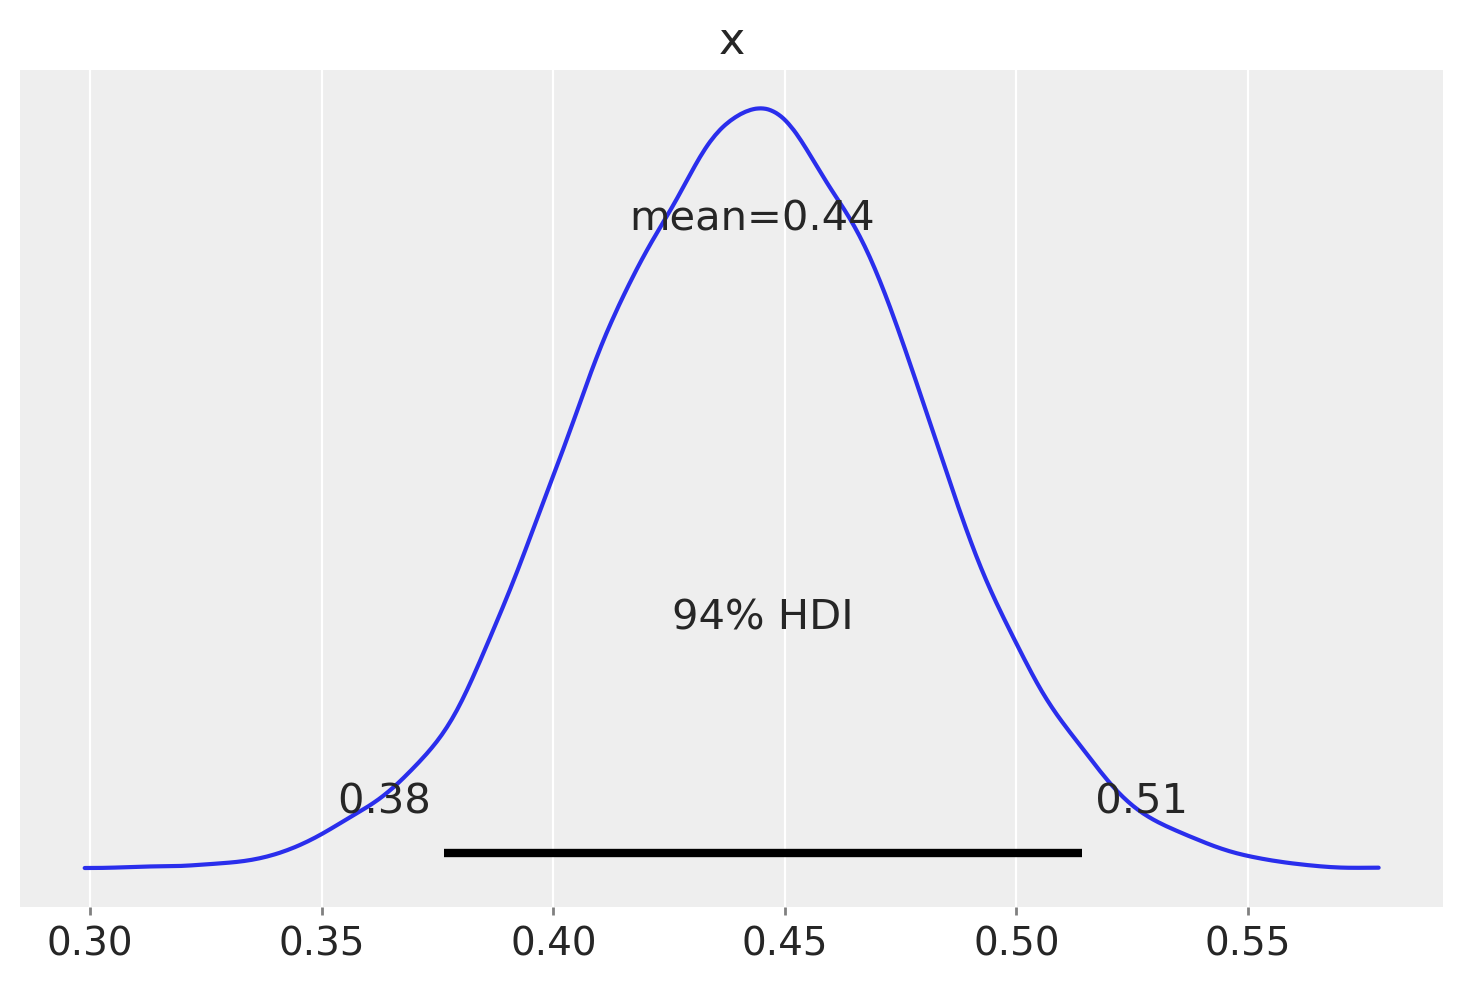

In [42]:
_ = az.plot_posterior(sample_posterior_x_means)

L'intervallo [0.37, 0.51] rappresenta l'intervallo di credibilità al 94% per la probabilità di risposta corretta `p`, considerando l'insieme del gruppo degli operatori. Questo intervallo ci fornisce un'indicazione sulla variabilità delle probabilità di successo tra gli operatori, considerando sia le differenze tra di loro che le somiglianze all'interno del gruppo.

Poiché l'intervallo di credibilità include il valore 0.5, possiamo concludere che non ci sono evidenze credibili che gli operatori, considerati nel loro insieme, siano in grado di "percepire il campo energetico di una persona senza vedere le mani" ad un livello diverso rispetto a quello che ci si potrebbe aspettare dal caso soltanto. 

## Informazioni sull'Ambiente di Sviluppo

In [43]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanpy 

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sun Jul 14 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

cmdstanpy: 1.2.4

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.9.1
cmdstanpy : 1.2.4
pandas    : 2.2.2
logging   : 0.5.1.2
arviz     : 0.18.0
requests  : 2.32.3
numpy     : 1.26.4

Watermark: 2.4.3

